In [1]:
#Load wrangling libraries
import numpy as np
import pandas as pd
from pathlib import Path
pd.set_option('max_columns', 30)  # Show all columns
pd.set_option('max_colwidth', 100)

#Load Machine Learning libraries
from sklearn.model_selection import train_test_split, KFold
from prince import MCA, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
def match(X_train_cat, X_test_cat):
    
    '''
    Description: This function checks the categorical features 
    between training and testing sets. If it detects dimension mismatch, it will make each categorical variables in 
    the training and testing tests have the same number of levels.
    input : 
        X_train_cat: dataframe, categorical predictors of training set
        X_test_cat: dataframe, categorical predictors of testing set
    output:
        X_train_cat, X_test_cat = dataframes , 
            having number of levels same as each other
    
    '''
    
    keep = X_train_cat.nunique() == X_test_cat.nunique()
    X_train_cat = X_train_cat[X_train_cat.columns[keep]]
    X_test_cat = X_test_cat[X_test_cat.columns[keep]]

    # For categorical features that have same levels, make sure the classes are the same
    keep = []
    for i in range(X_train_cat.shape[1]):
        keep.append(all(np.sort(X_train_cat.iloc[:,i].unique()) == np.sort(X_test_cat.iloc[:,i].unique())))
    X_train_cat = X_train_cat[X_train_cat.columns[keep]]
    X_test_cat = X_test_cat[X_test_cat.columns[keep]]
    
    return X_train_cat, X_test_cat

In [3]:
def seperation(X):
    """
    Description : This functions separates the features into numerical and categorical
    input :
        X : dataframe
    output :
        X_cat : dataframe , categorical features
        X_num : dataframe, numerical features
    
    """
    X_cat = X.select_dtypes(include = 'object')
    X_num = X.select_dtypes(exclude = 'object')
    
    return X_cat, X_num

## Data Profile

In [4]:
# Load data set
file_path = Path('D:\SFSU\job\Data Analyst\RAPP\RAPP_car_data.csv')
data = pd.read_csv(file_path , index_col = None)
data = data.drop(['id','symboling'], axis = 1)

# Show data, its dimensions, and types
display(data.head())
print(data.shape)
display(data.dtypes)

,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


(205, 25)


normalized-losses    float64
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                 float64
stroke               float64
compression-ratio    float64
horsepower           float64
peak-rpm             float64
city-mpg               int64
highway-mpg            int64
price                float64
dtype: object

In [5]:
# Display the missing values within each column
data.isnull().sum()

normalized-losses    41
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

<AxesSubplot:>

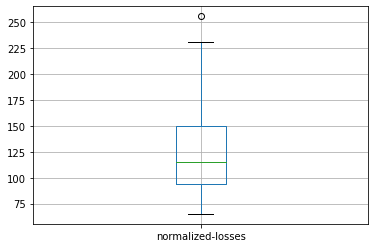

In [6]:
# Show the data distribution in normalized-losses
data.boxplot(column = ['normalized-losses'])

In [7]:
# To avoid considering the outliers in our dataset, replace the missing values in the 'normalized-losses' column with its median value
data['normalized-losses'].fillna(data['normalized-losses'].dropna().median(), inplace = True)

# Drop other missing values
data.dropna(inplace = True)

In [8]:
# Show unique values in each categorical column
data.select_dtypes(include = 'object').apply(lambda x : set(x))

make                {honda, volvo, chevrolet, bmw, isuzu, peugot, porsche, subaru, audi, toyota, mercedes-benz, dodg...
fuel-type                                                                                                 {gas, diesel}
aspiration                                                                                                 {std, turbo}
num-of-doors                                                                                                {four, two}
body-style                                                              {convertible, sedan, hardtop, wagon, hatchback}
drive-wheels                                                                                            {4wd, fwd, rwd}
engine-location                                                                                           {front, rear}
engine-type                                                                                  {l, dohc, ohcf, ohcv, ohc}
num-of-cylinders                        

In [9]:
# Define the Predictors and the response value
X = data.copy()

y = X['price']
del X['price']

In [10]:
# Split the data into training and testing sest
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = .2, random_state = 862)

In [11]:
# Tune PCA and MCA

pca_n_components = range(5,20) #set range of numerical components to iterate
mca_n_components = range(2,8) #set range of categorical components to iterate


scaler = StandardScaler () #instantiate scaler

params = list(itertools.product(pca_n_components, mca_n_components))

validation_mse = []

#Ten-fold cross validation

for ind, param in enumerate(params):
    kfold = KFold(10,True, ind)
    temporary_mse = []
    
    for train_index, valid_index in kfold.split(X_train):
        X_training, Y_training = X_train.iloc[train_index], y_train.iloc[train_index] # training set
        X_validation, Y_validation = X_train.iloc[valid_index], y_train.iloc[valid_index] # validation set
        
        # Seperate categorical and numerical features
        X_training_cat, X_training_num = seperation(X_training)
        X_validation_cat, X_validation_num = seperation(X_validation)
        
        # Make same level categorical features of both training and validation 
        X_training_cat, X_validation_cat = match(X_training_cat, X_validation_cat)

        # Scale numerical data
        scaler.fit(X_training_num) #fit to training data
        X_training_num_S = pd.DataFrame(scaler.transform(X_training_num)) #transform both training and validation data
        X_validation_num_S = pd.DataFrame(scaler.transform(X_validation_num))
        X_training_num_S.columns = X_training_num.columns.values
        X_validation_num_S.columns = X_training_num.columns.values
        
        # Numerical Feature reduction
        pca = PCA(n_components = param[0])
        X_training_num_r = pca.fit_transform(X_training_num)     
        X_validation_num_r = pca.transform(X_validation_num) #transform validation set
        
        # Categorical Feature Reduction
        mca = MCA(n_components = param[1])
        X_training_cat_r = mca.fit_transform(X_training_cat)
        X_validation_cat_r = mca.transform(X_validation_cat) #transform validation set

        # Combine categorical and numerical together
        X_training = pd.concat([X_training_cat_r, X_training_num_r] , axis = 1 )
        X_validation = pd.concat([X_validation_cat_r, X_validation_num_r] , axis = 1 )
                
        # Perform regression fitting
        model = LinearRegression()
        model.fit(X_training, Y_training)
        
        temporary_mse.append(mean_squared_error(Y_validation, model.predict(X_validation)))
    
    validation_mse.append(np.mean(temporary_mse))   
        

In [12]:
#Print best parameters,MSE, and RMSE
best_combination = params[np.argmin(validation_mse)]
print ('Best parameters:', best_combination)
print ('MSE:', (np.min(validation_mse)))
print ('RMSE:', (np.sqrt(np.min(validation_mse))))

Best parameters: (11, 6)
MSE: 9305978.585981868
RMSE: 3050.570206696097
